In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import time
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

# Define the path to the quantized model
quantized_model_path = r'/content/drive/MyDrive/R&D Project/Models/Quantized_Customized_ResNet_Model.tflite'

# Load the quantized model using tf.lite.Interpreter
interpreter = tf.lite.Interpreter(model_path=quantized_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preparing data generators for testing
data_path = r'/content/drive/MyDrive/R&D Project/Datasets/Dataset (Vehicles)'

# Testing data generator
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_generator = test_datagen.flow_from_directory(
    data_path + '/test',  # Use the testing set directory directly
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False to get predictions in order
)

# Calculate the total number of batches
total_batches = len(test_generator)

# Evaluate model accuracy on the testing set
correct_predictions = 0
total_samples = 0

# Iterate through batches
for batch_index in range(total_batches):
    inputs, true_labels = test_generator.next()

    # Ensure the batch size matches the expected size
    interpreter.set_tensor(input_details[0]['index'], inputs)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])

    predicted_classes = tf.argmax(predictions, axis=1)
    true_classes = tf.argmax(true_labels, axis=1)

    correct_predictions += tf.reduce_sum(tf.cast(tf.equal(predicted_classes, true_classes), tf.float32)).numpy()
    total_samples += inputs.shape[0]

# Calculate accuracy
accuracy = correct_predictions / total_samples if total_samples != 0 else 0

print(f'Quantized Custom ResNet\'s Accuracy on Testing Set: {accuracy * 100:.2f}%')


Mounted at /content/drive
Found 250 images belonging to 5 classes.
Quantized Custom ResNet's Accuracy on Testing Set: 95.20%


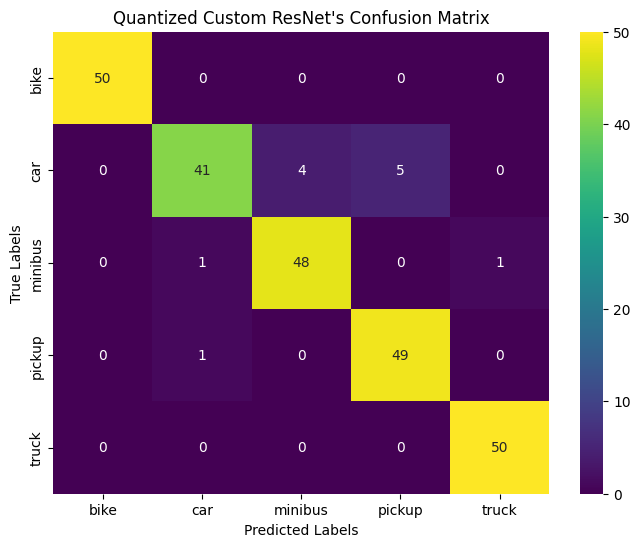

In [2]:
# Get predictions
interpreter.reset_all_variables()
predictions = []
true_labels = []

for _ in range(total_batches):
    inputs, labels = test_generator.next()
    interpreter.set_tensor(input_details[0]['index'], inputs)
    interpreter.invoke()
    predictions.extend(interpreter.get_tensor(output_details[0]['index']))
    true_labels.extend(labels)

predicted_classes = tf.argmax(predictions, axis=1)

import numpy as np
# Convert true_labels to class indices (multiclass format)
true_classes = np.argmax(true_labels, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
class_names = ['bike', 'car', 'minibus', 'pickup', 'truck']

# Visualize confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.viridis, xticklabels=class_names, yticklabels=class_names)
plt.title('Quantized Custom ResNet\'s Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [3]:
# Convert true_labels to class indices (multiclass format)
true_classes = np.argmax(true_labels, axis=1)

# Display classification report
print("Quantized Custom ResNet Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

Quantized Custom ResNet Classification Report:
              precision    recall  f1-score   support

        bike       1.00      1.00      1.00        50
         car       0.95      0.82      0.88        50
     minibus       0.92      0.96      0.94        50
      pickup       0.91      0.98      0.94        50
       truck       0.98      1.00      0.99        50

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250



In [6]:
# Get a single image for inference
image, _ = test_generator.next()

# Measure inference time
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()
inference_time = time.time() - start_time

# Display the inference time
print(f'Quantized Custom ResNet\'s Inference Time (for a single image): {inference_time:.4f} seconds')

Quantized Custom ResNet's Inference Time (for a single image): 0.2758 seconds
